In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [127]:
from proj1_helpers import *
DATA_TRAIN_PATH = 'C:\\Users\\asus\\Documents\\GitHub\\ML_course\\projects\\project1\\data\\train.csv' # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

## Do your thing crazy machine learning thing here :) ...

In [128]:
from implementations import *

In [129]:
#Normalize the data
centered_data = tX - np.mean(tX, axis=0)
tX = centered_data / np.std(centered_data, axis=0)
y[y == -1] = 0

In [53]:
#Find the correlations btw all columns and delete rows that are highly correlated
corr_mtx = np.identity(30)
for i in range(31):
    for j in range(i,30):
        corr_mtx[i,j] = np.corrcoef(tX[:,i], tX[:,j])[0,1]
        if corr_mtx[i,j]>0.95 and i!=j:
            print(i,j)

9 29


In [130]:
tX = np.delete(tX, np.array([6, 12,24,25,26,27,28,29]), axis=1)

In [131]:
least_squares_GD(y, tX, np.zeros(tX.shape[1]), 50, 0.001)

(array([ 5.26859500e-03, -7.84323320e-03, -3.16503693e-04,  3.97139070e-03,
         2.81393343e-03,  3.99886046e-03,  5.46361578e-04, -5.65764883e-04,
         3.03164606e-03, -4.40981843e-03,  5.88958959e-03,  5.16320471e-03,
        -2.59556495e-05, -1.02695628e-04, -7.87572705e-04,  2.49855231e-05,
         9.48878243e-05,  3.10719181e-04,  1.63547941e-04,  2.62464469e-03,
         2.55812243e-03,  3.17921873e-03]), 0.33288550699346)

In [134]:
least_squares_GD(y, tX, np.zeros(tX.shape[1]), 50, 0.0001)

(array([ 5.63201952e-04, -8.28714613e-04, -3.31581250e-05,  4.50321999e-04,
         3.30121712e-04,  4.49015617e-04,  3.19223891e-05, -3.85635716e-05,
         3.56983557e-04, -4.61360154e-04,  6.38845431e-04,  5.53724467e-04,
        -2.27874070e-06, -1.04317274e-05, -7.62559527e-05,  3.47705641e-06,
         9.75991132e-06,  5.07805270e-05,  1.75920477e-05,  3.15098196e-04,
         3.10210826e-04,  3.67866209e-04]), 0.3415018920287317)

0.337812023619296

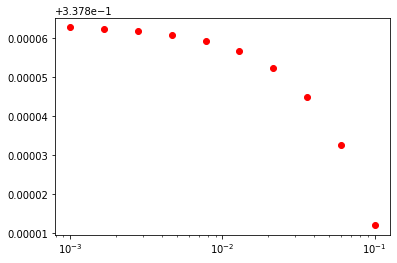

In [7]:
num_gamma = 10
least_squares_loss = np.ones(num_gamma)
gamma = np.logspace(-3, -1, num_gamma)
for i in range(num_gamma):
    least_squares_loss[i] = least_squares_GD(y, tX, np.ones(tX.shape[1]), 50, gamma[i])[1]
plt.plot(gamma, least_squares_loss, 'ro')
plt.xscale('log')
np.min(least_squares_loss)

In [136]:
least_squares_SGD(y, tX, np.ones(tX.shape[1]), 50, 0.001)

(array([0.95553731, 1.04115775, 0.94727253, 0.69607835, 0.72597254,
        0.70452605, 1.15738707, 0.92497054, 0.67218383, 1.06525226,
        0.83783813, 0.63038831, 0.9598901 , 0.8350971 , 0.94894062,
        1.00520199, 0.95058666, 0.84982689, 0.99732738, 0.65647604,
        0.75503761, 0.78800625]), 48.52016211819277)

0.8084637594708062

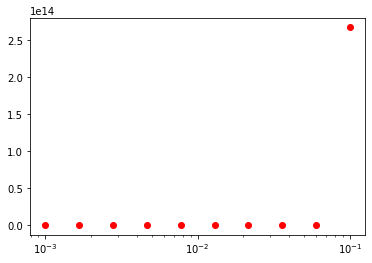

In [77]:
num_gamma = 10
least_squares_loss_SG = np.ones(num_gamma)
gamma = gamma = np.logspace(-3, -1, num_gamma)
for i in range(num_gamma):
    least_squares_loss_SG[i] = least_squares_SGD(y, tX, np.ones(tX.shape[1]), 200, gamma[i])[1]
plt.plot(gamma, least_squares_loss_SG, 'ro')
plt.xscale('log')
np.min(least_squares_loss_SG)

In [137]:
least_squares(y, tX)

(array([ 0.01457775, -0.12673899, -0.12745413, -0.01694001, -0.08993026,
         0.20927023,  0.13388932, -0.00050725, -0.07308316, -0.09132203,
         0.05763819,  0.11023857, -0.00032171, -0.00054586,  0.15797759,
        -0.00043332,  0.0012556 ,  0.06044576,  0.00050283, -0.03165107,
        -0.09071907,  0.07996976]), 0.28744464469757697)

In [138]:
ridge_regression(y, tX, 0.02)

(array([ 0.02074855, -0.11421443, -0.0920186 , -0.00077868, -0.04247097,
         0.13761996,  0.10431579, -0.00810759, -0.03863204, -0.06988994,
         0.05813532,  0.09582814, -0.00044968, -0.00074823,  0.10749807,
        -0.00036194,  0.00119516,  0.04380157,  0.00059088, -0.03638813,
        -0.06717489,  0.05004489]), 0.2906412127080359)

0.28693112829048006

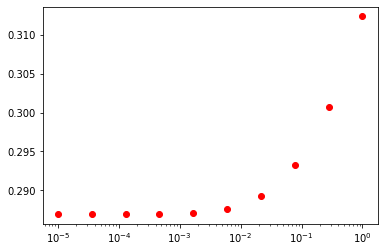

In [80]:
num_lambda = 10
ridge_regression_loss = np.ones(num_lambda)
lambda_ =  np.logspace(-5, 0, num_lambda)
for i in range(num_lambda):
    ridge_regression_loss[i] = ridge_regression(y, tX, lambda_[i])[1]
plt.plot(lambda_, ridge_regression_loss, 'ro')
plt.xscale('log')
np.min(ridge_regression_loss)

In [152]:
from implementations import *

In [140]:
logistic_regression(y, tX, np.zeros(tX.shape[1]), 1000, 0.01)

(array([ 9.96116094e-01,  1.13500516e-03, -1.66788256e-03, -6.67065488e-05,
         9.13732961e-04,  6.72254092e-04,  9.10124848e-04,  5.81172453e-05,
        -7.25543657e-05,  7.27260128e-04, -9.27361466e-04,  1.28973865e-03,
         1.11644311e-03, -4.47668425e-06, -2.08945173e-05, -1.51623746e-04,
         7.19607677e-06,  1.95794378e-05,  1.06622807e-04,  3.54780907e-05,
         6.43181277e-04,  6.33826223e-04,  7.47991736e-04]), 0.967900856068734)

In [141]:
reg_logistic_regression(y, tX, 0.01, np.zeros(tX.shape[1]), 10000, 1)

(array([ 6.01609421e-01,  1.13500516e-01, -1.66788256e-01, -6.67065488e-03,
         9.13732961e-02,  6.72254092e-02,  9.10124848e-02,  5.81172453e-03,
        -7.25543657e-03,  7.27260128e-02, -9.27361466e-02,  1.28973865e-01,
         1.11644311e-01, -4.47668425e-04, -2.08945173e-03, -1.51623746e-02,
         7.19607677e-04,  1.95794378e-03,  1.06622807e-02,  3.54780907e-03,
         6.43181277e-02,  6.33826223e-02,  7.47991736e-02]),
 0.7699150312170796)

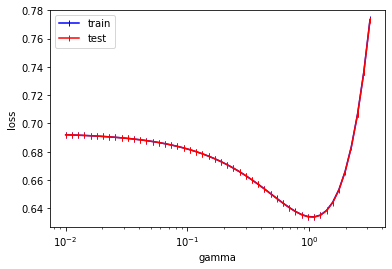

In [144]:
tr, te, gammas = cross_validation_gamma(y, tX)

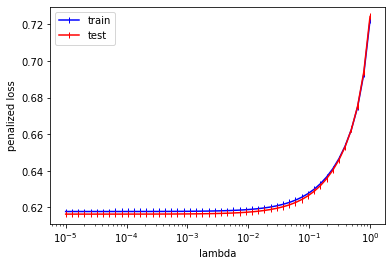

In [148]:
tr, te, lambdas = cross_validation_lambda(y[0:10000], tX[0:10000])

In [ ]:
e1, e2 = bias_variance_demo(y[0:10], tX[0:10])

C:\Users\asus\Documents\GitHub\EPFL-Machine-Learning-Higgs-2019\scripts\implementations.py:131: RuntimeWarning: invalid value encountered in true_divide
  #gradient /= tx.shape[0]
C:\Users\asus\Documents\GitHub\EPFL-Machine-Learning-Higgs-2019\scripts\implementations.py:122: RuntimeWarning: invalid value encountered in double_scalars
  #loss /= tx.shape[0]


## Generate predictions and save ouput in csv format for submission:

In [10]:
DATA_TEST_PATH = '' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [31]:
OUTPUT_PATH = '' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)